In [1]:
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import ipyleaflet 
# import dtv_backend.fis
import opentnsim.strategy
import opentnsim.energy

In [2]:
# Go to the Digital Twin Vaarwegen website and click together a scenario. Export the scenario.

In [3]:
# # Load the config file with all the settings
# with open('../tests/data/ect-bctn.json') as f:
#     config = json.load(f)
    

In [4]:
# Load the config file with all the settings
with open('Rotterdam2Lobith.json') as f:
    config = json.load(f)

In [5]:
# Show the list of settings in the config file
config.keys()

dict_keys(['route', 'waypoints', 'sites', 'fleet', 'operator', 'climate', 'quantities', 'options'])

In [6]:
# Load the waypoints
waypoints_gdf = gpd.GeoDataFrame.from_features(config['waypoints'])
route_gdf = gpd.GeoDataFrame.from_features(config['route'])
fleet_gdf = gpd.GeoDataFrame.from_features(config['fleet'])
sites_gdf = gpd.GeoDataFrame.from_features(config['sites'])
bathymetry_gdf = gpd.GeoDataFrame.from_features(config['quantities']['bathymetry'])
velocities_gdf = gpd.GeoDataFrame.from_features(config['quantities']['velocities'])
waterlevel_gdf = gpd.GeoDataFrame.from_features(config['quantities']['waterlevels'])

In [7]:
fleet_gdf.columns.values

array(['geometry', 'CEMT-class', 'RWS-class', 'Vessel type',
       'Description (English)', 'Description (Dutch)', 'Beam [m]',
       'Beam 10% percentile [m]', 'Beam 50% percentile [m]',
       'Beam 90% percentile [m]', 'Length [m]',
       'Length 10% percentile [m]', 'Length 50% percentile [m]',
       'Length 90% percentile [m]', 'Draught loaded [m]',
       'Draught average [m]', 'Draught empty [m]', 'Height average [m]',
       'Load Weight average [ton]', 'Load weight maximum [ton]', 'speed',
       'image', 'capacity', 'name', 'count'], dtype=object)

In [28]:
route_gdf

,geometry,e,is_stop,length_m,length_m_cumsum,n,segment,source,step,structure,target
0,"LINESTRING (4.54314 51.90408, 4.54304 51.90406)","[B4308_B, B4308_A]",False,11.059402,11.059402,B4308_B,0,B4308_B,0,"{'structure_code': 'B', 'structure_id': '4308'...",8865010
1,"LINESTRING (4.54737 51.90485, 4.54314 51.90408)","[B4308_A, 8861191]",False,475.644319,486.703721,B4308_A,0,B4308_B,1,None,8865010
2,"LINESTRING (4.54875 51.90507, 4.54737 51.90485)","[8861191, 8867588]",False,154.100958,640.804680,8861191,0,B4308_B,2,None,8865010
3,"LINESTRING (4.55362 51.90583, 4.54875 51.90507)","[8867588, 8863742]",False,544.992586,1185.797265,8867588,0,B4308_B,3,None,8865010
4,"LINESTRING (4.55574 51.90563, 4.55362 51.90583)","[8863742, 32506833]",False,236.043364,1421.840629,8863742,0,B4308_B,4,None,8865010
...,...,...,...,...,...,...,...,...,...,...,...
70,"LINESTRING (6.06350 51.86545, 6.06350 51.86545...","[30985662, Berth220]",False,2137.893237,186482.757038,30985662,1,8865010,3,None,8862687
71,"LINESTRING (6.08111 51.85756, 6.08111 51.85756...","[Berth220, 22638200]",False,17.657422,186500.414460,Berth220,1,8865010,4,None,8862687
72,"LINESTRING (6.08125 51.85749, 6.08125 51.85749...","[22638200, 8862401]",False,813.965984,187314.380444,22638200,1,8865010,5,None,8862687
73,"LINESTRING (6.08754 51.85367, 6.08754 51.85367...","[8862401, 8862687]",False,855.474520,188169.854965,8862401,1,8865010,6,None,8862687


In [8]:
waterlevel_gdf

,geometry,lat_p5,lat_p50,lat_p95,length_m,nap_p5,nap_p50,nap_p95,source,target,velocity,waterlevel
0,"LINESTRING (5.86454 51.75811, 5.85509 51.75922...",None,None,None,1711.892433,-1.885903,-1.677511,-1.428162,8865600,8866220,NaN,7.930000
1,"LINESTRING (5.86454 51.75811, 5.86354 51.75873...",None,None,None,259.494504,-1.241347,1.964048,2.550113,8865600,8862668,NaN,7.930000
2,"LINESTRING (5.87067 51.75530, 5.87000 51.75564...",None,None,None,745.783304,-1.949700,-1.203419,2.701228,8865600,B26155_B,NaN,7.930000
3,"LINESTRING (5.84912 51.75925, 5.84918 51.75861)",None,None,None,70.424775,-1.549043,0.159349,2.270192,8866220,22637997,NaN,7.929200
4,"LINESTRING (5.84912 51.75925, 5.84676 51.75919...",None,None,None,1195.262754,-2.135228,-1.998290,-1.627417,8866220,B34645_A,NaN,7.929200
...,...,...,...,...,...,...,...,...,...,...,...,...
928,"LINESTRING (5.22515 51.81664, 5.22378 51.81631)",None,None,None,155.974627,-14.558473,-14.142607,-13.786260,Berth300,Berth301,1.01,1.962397
929,"LINESTRING (5.22378 51.81631, 5.22242 51.81599)",None,None,None,153.638585,-15.261757,-14.721581,-14.247894,Berth301,Berth302,1.01,1.962397
930,"LINESTRING (5.22242 51.81599, 5.22108 51.81567)",None,None,None,152.821400,-15.326326,-15.294893,-15.257273,Berth302,Berth303,1.01,1.962397
931,"LINESTRING (5.22108 51.81567, 5.21902 51.81518)",None,None,None,234.095871,-15.266959,-11.524971,-3.204976,Berth303,8865499,1.01,1.962397


In [9]:
bathymetry_gdf

,geometry,lat_p5,lat_p50,lat_p95,length_m,nap_p5,nap_p50,nap_p95,source,target,velocity,waterlevel
0,"LINESTRING (4.95297 52.37655, 4.95421 52.37443)",NaN,NaN,NaN,271.818288,-6.427046,-6.190280,-5.997982,8867414,8865307,NaN,NaN
1,"LINESTRING (4.95297 52.37655, 4.94879 52.37588)",NaN,NaN,NaN,468.352421,-6.115227,-5.262437,-4.721988,8867414,8864869,NaN,NaN
2,"LINESTRING (4.95291 52.37705, 4.95297 52.37655)",NaN,NaN,NaN,55.750050,-6.548604,-6.499455,-6.453733,8867414,Berth82,NaN,NaN
3,"LINESTRING (4.95421 52.37443, 4.95517 52.37375)",NaN,NaN,NaN,130.292242,-6.979173,-6.904762,-6.059947,8865307,8862258,NaN,NaN
4,"LINESTRING (4.95421 52.37443, 4.95246 52.37354...",NaN,NaN,NaN,314.467416,-5.793301,-5.473814,-4.488499,8865307,8868262,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3190,"LINESTRING (5.22515 51.81664, 5.22378 51.81631)",NaN,NaN,NaN,155.974627,-14.558473,-14.142607,-13.786260,Berth300,Berth301,1.01,1.962397
3191,"LINESTRING (5.22378 51.81631, 5.22242 51.81599)",NaN,NaN,NaN,153.638585,-15.261757,-14.721581,-14.247894,Berth301,Berth302,1.01,1.962397
3192,"LINESTRING (5.22242 51.81599, 5.22108 51.81567)",NaN,NaN,NaN,152.821400,-15.326326,-15.294893,-15.257273,Berth302,Berth303,1.01,1.962397
3193,"LINESTRING (5.22108 51.81567, 5.21902 51.81518)",NaN,NaN,NaN,234.095871,-15.266959,-11.524971,-3.204976,Berth303,8865499,1.01,1.962397


<AxesSubplot:>

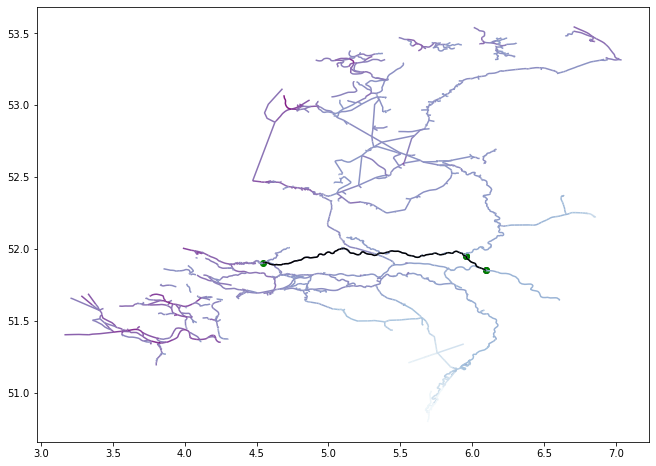

In [10]:
fig, ax = plt.subplots(figsize=(13, 8))
bathymetry_gdf.plot('nap_p50', cmap='BuPu_r', ax=ax)
route_gdf.plot(ax=ax, color='black')
waypoints_gdf.plot(ax=ax, color='green')
fleet_gdf.plot(ax=ax, color='red')

In [11]:
# take the center of the route
center_geometry = route_gdf.dissolve().centroid.iloc[0]
# lon/lat - lat/lon 
center = (center_geometry.y, center_geometry.x)

# add map
m = ipyleaflet.Map(center=center, zoom=8)

# add the layers
route_geo_data = ipyleaflet.GeoData(geo_dataframe = route_gdf, name = 'route')
m.add_layer(route_geo_data)
fleet_geo_data = ipyleaflet.GeoData(geo_dataframe = fleet_gdf, name = 'fleet', style={'color': 'red'})
m.add_layer(fleet_geo_data)

# show the map
m

Map(center=[51.9482088959333, 5.331182306451976], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [18]:
def compute_draught_load_fraction(vessel_row):
    level = 280
    capacity = 400
    filling_degree = level / capacity
    T_f = vessel_row['Draught loaded [m]']
    T_e = vessel_row['Draught empty [m]']
    T_range = T_f - T_e
    T = (T_range * filling_degree) + T_e
    return T

def create_vessel(vessel_row, **kwargs):
    model_input = {
        'L': vessel_row['Length [m]'],
        'B': vessel_row['Beam [m]'],
        'C_B': 0.85,
        'type': vessel_row['RWS-class'],
        'P_installed': 1750,
        'L_w': 3,
        'C_year': 2000,
        'P_hotel_perc': 0.05
    }
    model_input.update(**kwargs)

    Vessel = type('Vessel', (opentnsim.core.VesselProperties, opentnsim.energy.ConsumesEnergy), {})
    vessel = Vessel(**model_input)
    return vessel

def compute_draught_dorsser(vessel_row):
    vessel = create_vessel(vessel_row)
    payload_strategy = vessel_row['Load Weight average [ton]']
    
    T = opentnsim.strategy.Payload2T(vessel=vessel, Payload_strategy=payload_strategy, vessel_type='Container')
    return T

    

In [19]:
# def compute_draught_load_fraction(vessel_row):
#     level = 280
#     capacity = 400
#     filling_degree = level / capacity
#     T_f = vessel_row['Draught loaded [m]']
#     T_e = vessel_row['Draught empty [m]']
#     T_range = T_f - T_e
#     T = (T_range * filling_degree) + T_e
#     return T

# def create_vessel(vessel_row, **kwargs):
#     model_input = {
#         'L': vessel_row['Length [m]'],
#         'B': vessel_row['Beam [m]'],
#         'type': vessel_row['RWS-class'],
#         'P_installed': float(vessel_row['Engine power maximum [kW]']),
#         'L_w': 3,
#         'C_year': 2000,
#         'P_hotel_perc': 0.05
#     }
#     model_input.update(**kwargs)

#     Vessel = type('Vessel', (opentnsim.core.VesselProperties, opentnsim.energy.ConsumesEnergy), {})
#     vessel = Vessel(**model_input)
#     return vessel

# def compute_draught_dorsser(vessel_row):
#     vessel = create_vessel(vessel_row)
#     payload_strategy = vessel_row['Load Weight average [ton]']
    
#     T = opentnsim.strategy.Payload2T(vessel=vessel, Payload_strategy=payload_strategy, vessel_type='Container')
#     return T

    

In [20]:
vessel_row = fleet_gdf.iloc[0]
print('load fraction method', compute_draught_load_fraction(vessel_row))
print('dorsser method', compute_draught_dorsser(vessel_row))

# Notebook 12.


load fraction method 2.87
2286 1047.114031240857 1.9098300562505255 Container
2286 2434.5818674206466 3.0901699437494736 Container
2286 2864.629930488176 3.819660112501051 Container
2286 2584.269065123362 3.215560626706412 Container
2286 1900.0106709733154 2.639320225002103 Container
2286 2284.727107366323 2.9642677605240473 Container
2286 2286.4289525592303 2.9656996820856967 Container
2286 2285.9987560162403 2.9653377220540738 Container
2286 2286.0027700055607 2.965341099370473 Container
2286 2285.99474202724 2.9653343447376743 Container
dorsser method 2.9653377220540738


In [23]:
T = compute_draught_load_fraction(vessel_row)
vessel = create_vessel(vessel_row, T=T, P_tot_given=500)

In [24]:
edge = {'Info': {'GeneralDepth': 5}}
opentnsim.energy.power2v(vessel, edge, upperbound=10)

3.678223421682266

In [25]:
{
  "ship_specification": {
    "length": 135,
    "width": 11.4,
    "design_draught": 3.5
  },
  "ship_loadcase": {
    "draught": 2.5
  },
  "ship_conditions": {
    "water_depth": 10,
    "speed": [
      1,
      3,
      5,
      7
    ]
  }
}

{'ship_specification': {'length': 135, 'width': 11.4, 'design_draught': 3.5},
 'ship_loadcase': {'draught': 2.5},
 'ship_conditions': {'water_depth': 10, 'speed': [1, 3, 5, 7]}}

In [ ]:
# calculate energy consumption along the edges 

In [ ]:
# add energy consumption per edge into the route data frame

In [ ]:
# add energy consumption layer to the street map

In [26]:
# calculate alternatives and add layers (LH2, e-LNG, methnal...) to the map

In [27]:
# arrange the energy maps by subplot